## Classification Model 

We're using the [MAGIC Gamma Telescope data from UCI repo](https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope) for this project. 

The steps taken in this project is as follows:
- [Loading and exploring the data](#loadex)
- [Random Forest Model](#randomf)
- [KNN Model](#knnmodel)
- [XGBoost Model](#xgbmodel)


The worset performace among the tested models was from KNN, followed by Random Forest, and XGBoost showed the highest accuracy among the tested model.

- [XGBoost Score](#xgbscore): 0.8885
- [Random Forest Score](#rfscore): 0.8851
- [KNN Score](#knnscore): 0.8483

In [1]:
## first the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## the sklearn modules
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## XGBoost module to compare
from xgboost import XGBClassifier

<a id='loadex'></a>
### Loading and exploring the data

In [2]:
## reading the data from its url
## and checking the overall format
magic_gamma = pd.read_csv('https://archive.ics.uci.edu/static/public/159/data.csv')
magic_gamma.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [3]:
magic_gamma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [4]:
## changing the types for improving the memory usage
def data_cleaner(df):
    datatype_dict = {}
    df.columns = [x.replace(r'\s+', '_').lower() for x in df.columns]
    for col in df.columns:
        ## dropping the columns that are mostly null values
        if df[col].isnull().sum()/df.shape[0] >= 0.5:
            df.drop(col, axis=1, inplace=True)
        elif df[col].dtype == 'object' and df[col].nunique() < 10:
            df[col] = df[col].str.replace(r'\s+','_', regex = True).str.lower()
            df = pd.get_dummies(data=df, columns = [col])
        elif df[col].dtype == 'object':
            df.drop(col, axis=1, inplace=True)
        elif df[col].dtype in ['float64', 'float32'] and df[col].min() == df.astype({col:'float16'})[col].min:
            datatype_dict[col] = 'float16'
        elif df[col].dtype == 'float64' and df[col].min() == df.astype({col:'float32'})[col].min:
            datatype_dict[col] = 'float32'
        elif df[col].dtype in ['int64', 'int32', 'int16'] and df[col].min() == df.astype({col:'int8'})[col].min:
            datatype_dict[col] = 'int8'
        elif df[col].dtype in ['int64', 'int32'] and df[col].min() == df.astype({col:'int16'})[col].min:
            datatype_dict[col] = 'int16'
        elif df[col].dtype in ['int64'] and df[col].min() == df.astype({col:'int32'})[col].min:
            datatype_dict[col] = 'int32'
    return df.astype(datatype_dict)
cleaned_magic = data_cleaner(magic_gamma.copy())
cleaned_magic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   flength   19020 non-null  float64
 1   fwidth    19020 non-null  float64
 2   fsize     19020 non-null  float64
 3   fconc     19020 non-null  float64
 4   fconc1    19020 non-null  float64
 5   fasym     19020 non-null  float64
 6   fm3long   19020 non-null  float64
 7   fm3trans  19020 non-null  float64
 8   falpha    19020 non-null  float64
 9   fdist     19020 non-null  float64
 10  class_g   19020 non-null  uint8  
 11  class_h   19020 non-null  uint8  
dtypes: float64(10), uint8(2)
memory usage: 1.5 MB


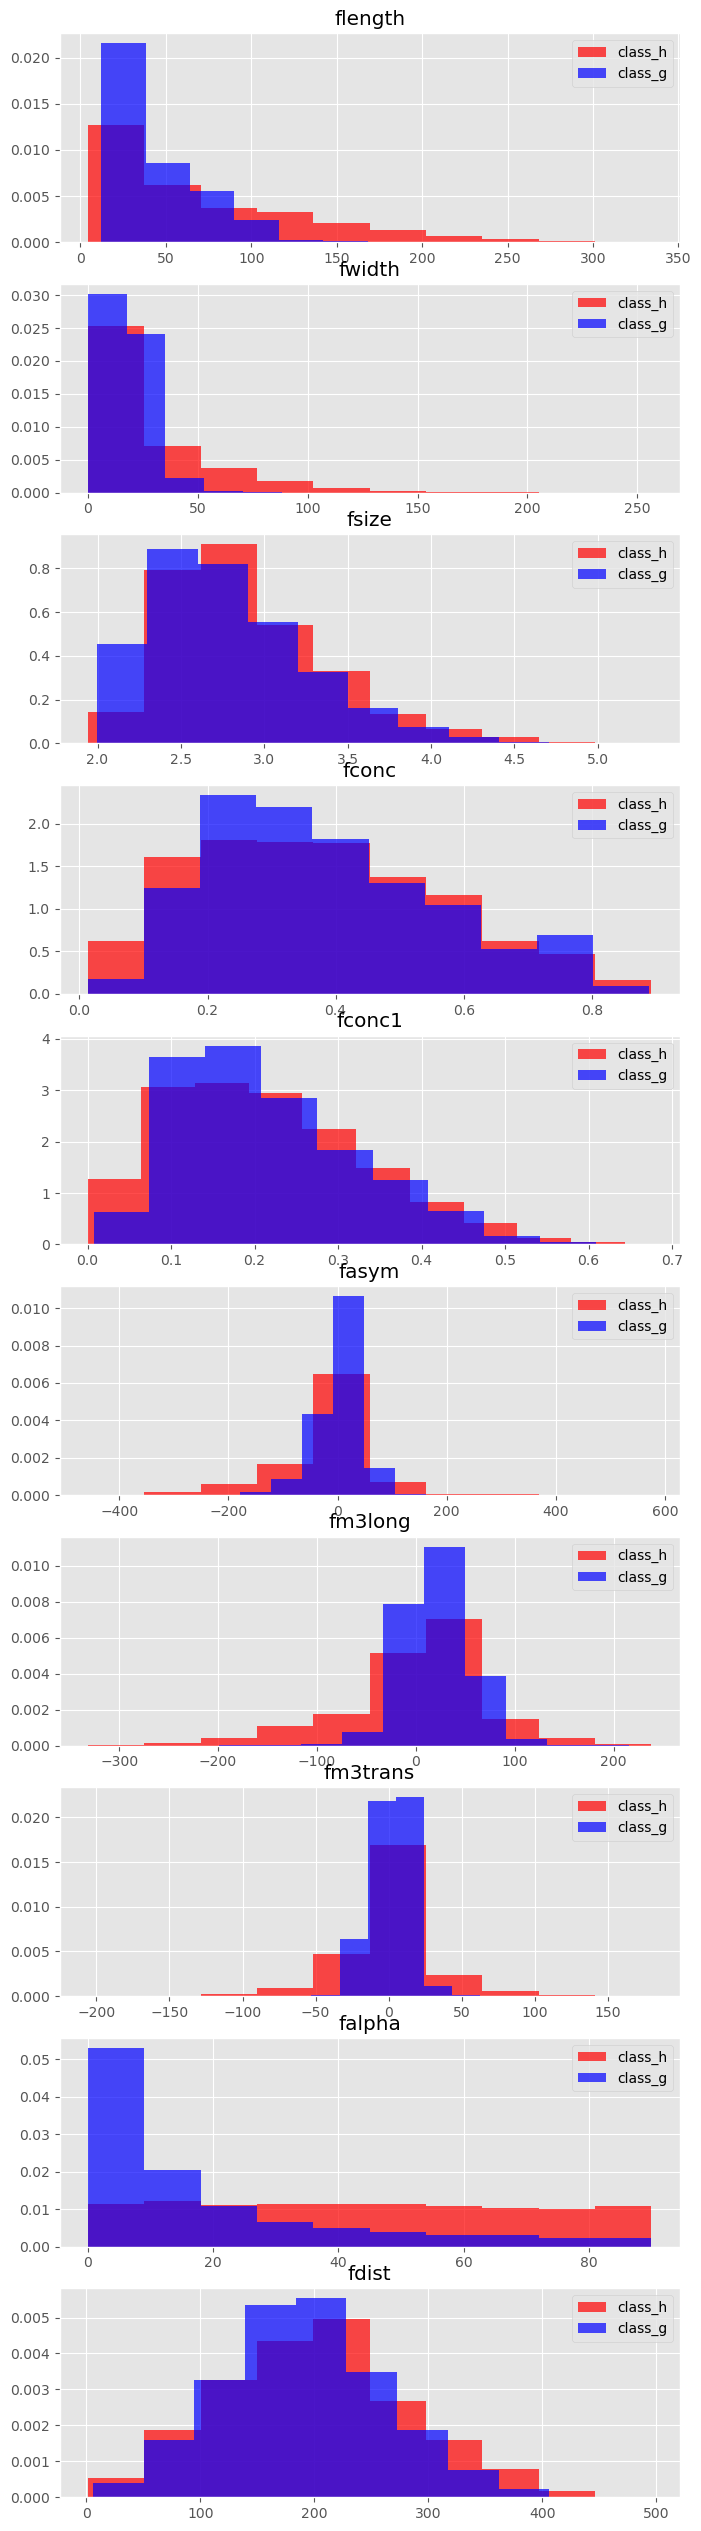

In [5]:
## some more explorations
plt.style.use('ggplot')
labels = ['class_h', 'class_g']
color_dict = {'class_h':'red', 'class_g':'blue'}
fig, ax = plt.subplots(nrows = int(len(cleaned_magic.drop(labels, axis=1).columns)),
                      figsize=(8,32))
c = 0
for col in cleaned_magic.columns:
    if col in labels:
        continue
    for l in labels:
        ax[c].hist(cleaned_magic[cleaned_magic[l] == 1][col], density=True,
                 label=l, color=color_dict[l], alpha=.7)
        ax[c].set_title(col)
    ax[c].legend()
    c +=1

In [6]:
## getting the proportion of each class
print(f" H : {round(sum(cleaned_magic['class_h'])/cleaned_magic.shape[0],2)*100} %")
print(f" G : {round(sum(cleaned_magic['class_g'])/cleaned_magic.shape[0],2)*100} %")

 H : 35.0 %
 G : 65.0 %


We have fewer H cases compared to G.

In [7]:
## splitting the data
random_seed = 60
X, y = cleaned_magic.drop(['class_g', 'class_h'], axis=1), cleaned_magic[['class_g', 'class_h']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=random_seed)

<a id='randomf'></a>
### Random Forest Model

In [8]:
## starting with the pipeline
pipe = Pipeline([('scale', StandardScaler()),
                ('model', RandomForestClassifier(random_state=random_seed))])
pipe.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler()),
  ('model', RandomForestClassifier(random_state=60))],
 'verbose': False,
 'scale': StandardScaler(),
 'model': RandomForestClassifier(random_state=60),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'model__bootstrap': True,
 'model__ccp_alpha': 0.0,
 'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': None,
 'model__max_features': 'auto',
 'model__max_leaf_nodes': None,
 'model__max_samples': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__min_weight_fraction_leaf': 0.0,
 'model__n_estimators': 100,
 'model__n_jobs': None,
 'model__oob_score': False,
 'model__random_state': 60,
 'model__verbose': 0,
 'model__warm_start': False}

In [9]:
## creating the grid search
params = {
    'model__ccp_alpha':[0.0, 0.1, 0.2],
    'model__max_depth':[2, 4, 6],
    'model__min_samples_split':[2, 4, 6],
    'model__n_estimators':[50, 100, 150],
}
gc = GridSearchCV(pipe,
                 param_grid=params,
                 cv = 3)
gc.fit(X_train, y_train)
best_model = gc.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, n_estimators=50,
                                        random_state=60))])

In [10]:
## second try
params2 = {
    'model__max_depth':[6, 8, 10],
    'model__min_samples_split':[2],
    'model__n_estimators':[30, 50, 80],
}
gc2 = GridSearchCV(pipe,
                 param_grid=params2,
                 cv = 3)
gc2.fit(X_train, y_train)
best_model = gc2.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=50,
                                        random_state=60))])

In [11]:
## 3rd try
params3 = {
    'model__max_depth':[10, 15, 20],
}
gc3 = GridSearchCV(pipe,
                 param_grid=params3,
                 cv = 3)
gc3.fit(X_train, y_train)
best_model = gc3.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=20, random_state=60))])

<a id='rfscore'></a>

In [12]:
best_model.score(X_test, y_test)

0.8851209253417456

<a id='knnmodel'></a>
### KNN Model

In [13]:
## starting with the pipeline again
pipe = Pipeline([('scale', StandardScaler()),
                ('model', KNeighborsClassifier())])
pipe.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler()), ('model', KNeighborsClassifier())],
 'verbose': False,
 'scale': StandardScaler(),
 'model': KNeighborsClassifier(),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 5,
 'model__p': 2,
 'model__weights': 'uniform'}

In [14]:
## creating the grid search for KNN
params = {
    'model__algorithm':['auto', 'kd_tree', 'brute'], 
    'model__n_neighbors':[2, 4, 6],
    'model__weights':['uniform', 'distance'],
    'model__leaf_size':[15, 30, 45],
}
gc = GridSearchCV(pipe,
                 param_grid=params,
                 cv = 3)
gc.fit(X_train, y_train)
best_model = gc.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 KNeighborsClassifier(leaf_size=15, n_neighbors=6,
                                      weights='distance'))])

In [15]:
## 2nd try
params2 = {
    'model__algorithm':['auto'], 
    'model__n_neighbors':[6, 8, 10],
    'model__weights':['uniform', 'distance'],
    'model__leaf_size':[10, 15, 20],
}
gc2 = GridSearchCV(pipe,
                 param_grid=params2,
                 cv = 3)
gc2.fit(X_train, y_train)
best_model = gc2.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=8,
                                      weights='distance'))])

In [16]:
## 3rd try
params3 = {
    'model__algorithm':['auto'], 
    'model__n_neighbors':[8],
    'model__weights':['distance'],
    'model__leaf_size':[8, 10, 12],
}
gc3 = GridSearchCV(pipe,
                 param_grid=params3,
                 cv = 3)
gc3.fit(X_train, y_train)
best_model = gc3.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 KNeighborsClassifier(leaf_size=8, n_neighbors=8,
                                      weights='distance'))])

In [17]:
## 4th try
params4 = {
    'model__algorithm':['auto'], 
    'model__n_neighbors':[8],
    'model__weights':['distance'],
    'model__leaf_size':[4, 6, 8],
}
gc4 = GridSearchCV(pipe,
                 param_grid=params4,
                 cv = 3)
gc4.fit(X_train, y_train)
best_model = gc4.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 KNeighborsClassifier(leaf_size=4, n_neighbors=8,
                                      weights='distance'))])

In [18]:
## 5th try
params5 = {
    'model__algorithm':['auto'], 
    'model__n_neighbors':[8],
    'model__weights':['distance'],
    'model__leaf_size':[2, 4, 5],
}
gc5 = GridSearchCV(pipe,
                 param_grid=params5,
                 cv = 3)
gc5.fit(X_train, y_train)
best_model = gc5.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 KNeighborsClassifier(leaf_size=2, n_neighbors=8,
                                      weights='distance'))])

<a id='knnscore'></a>

In [19]:
best_model.score(X_test, y_test)

0.8483175604626709

<a id='xgbmodel'></a>
### XGBoost Model

In [20]:
## starting with the pipeline again
pipe = Pipeline([('scale', StandardScaler()),
                ('model', XGBClassifier(random_state=random_seed))])
pipe.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler()),
  ('model',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=None, n_jobs=None,
                 num_parallel_tree=None, random_state=60, ...))],
 'verbose': False,
 'scale': StandardScaler(),
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsam

In [21]:
## creating the grid search for xgb
params = {
    'model__learning_rate':[0.001, 0.1, 0.2],
    'model__num_parallel_tree':[2, 4, 6],
    'model__max_depth':[4, 6, 8],
    'model__n_estimators':[50, 100, 150],
}
gc = GridSearchCV(pipe,
                 param_grid=params,
                 cv = 3)
gc.fit(X_train, y_train)
best_model = gc.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
      

In [22]:
## 2nd try
params2 = {
    'model__learning_rate':[0.20, 0.22, 0.25],
    'model__num_parallel_tree':[2],
    'model__max_depth':[8, 10, 12],
    'model__n_estimators':[130, 150, 180],
}
gc2 = GridSearchCV(pipe,
                 param_grid=params2,
                 cv = 3)
gc2.fit(X_train, y_train)
best_model = gc2.best_estimator_
best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
      

<a id='xgbscore'></a>

In [23]:
best_model.score(X_test, y_test)

0.8885383806519453

### Summary

The worset performace among the tested model was KNN, followed by Random Forest, and XGBoost showed the highest accuracy among the tested model.

- [XGBoost Score](#xgbscore): 0.8885
- [Random Forest Score](#rfscore): 0.8851
- [KNN Score](#knnscore): 0.8483